#Bank Churn prediction Model Improvement


### **Objective**:

The objective of this notebook is to provide information of the improvements that were attempted in improving the best model for Project_1, using differente architectures and techniques. 

A simplified version of the model is given for clarity and time purposes.

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
# Library to split data
from sklearn.model_selection import train_test_split
# Library to encode the variables
from sklearn import preprocessing
# To plot confusion matrix
from sklearn.metrics import confusion_matrix
# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# library to import to standardize the data
from sklearn.preprocessing import StandardScaler
#To import different metrics 
from sklearn import metrics
from tensorflow.keras import backend
# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")
# importing different functions to build models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
# importing GridSearch CV
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Preparation

In [3]:
#Read the data set 
ds = pd.read_csv("data.csv")

In [4]:
ds.shape

(10000, 14)

In [5]:
# creating a copy of the data so that original data remains unchanged
df = ds.copy()

In [6]:
# RowNumber , CustomerId and Surname are unique hence drop them
ds = ds.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1) 

In [7]:
#Split features and target variables
X = ds.drop(['Exited'],axis=1)  
y = ds[['Exited']]      

In [8]:
# Splitting the dataset into the Training and Testing set.

X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y,shuffle = True) 

In [9]:
# Splitting the dataset into the Training and Testing set.

X_train, X_val, y_train, y_val = train_test_split(X_large,y_large, test_size = 0.2, random_state = 42,stratify=y_large, shuffle = True) 

In [10]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in train data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 6400
Number of rows in train data = 1600
Number of rows in test data = 2000


In [11]:
# Encoding Geography variable
X_train = pd.get_dummies(X_train, columns=["Geography","Gender"],drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Geography","Gender"],drop_first=True)   
X_val = pd.get_dummies(X_val, columns=["Geography","Gender"],drop_first=True)     

In [12]:
# Scaling the data with standardscaler
sc=StandardScaler()
temp = sc.fit(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])

In [13]:
#Function for plotting Confusion Matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Model Building and Improvement. 

- In this section we take as a baseline model, Model 3 from the Project 1 and we will try different architectures and techniques to see if we can improve it.


In [14]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
import random
random.seed(2)
tf.random.set_seed(2)

In [15]:
#Initializing the neural network
model_3 = Sequential()

model_3.add(Dense(32,activation='relu',input_dim = X_train.shape[1]))
model_3.add(Dropout(0.2))
model_3.add(Dense(16,activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(8,activation='relu'))

model_3.add(Dense(1, activation = 'sigmoid'))

In [16]:
# Initialize and compile model 

optimizer = tf.keras.optimizers.Adam(0.001)
model_3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [17]:
# Defining Early stopping
from keras import callbacks 
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

In [18]:
# Fit the model 
history_3 = model_3.fit(X_train,y_train,batch_size=32,epochs=100,verbose=0,validation_data=(X_val,y_val),callbacks=[es_cb])

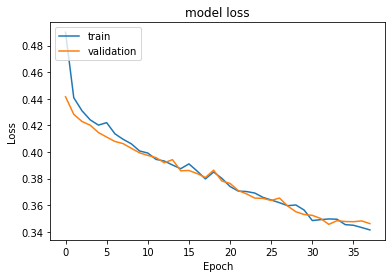

In [19]:
# Plot the Loss 
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

200/200 [==============================] - 0s 2ms/step
Best Threshold=0.197977, G-Mean=0.794


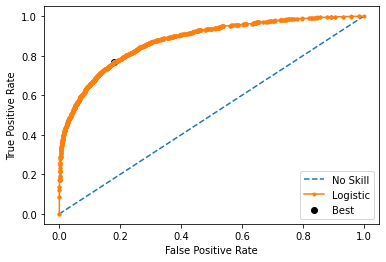

In [20]:
# Balance performance classification threshold with ROC curves

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat = model_3.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [21]:
#Predicting the results using best as a threshold
y_pred_e=model_3.predict(X_val)
y_pred_3 = (y_pred_e > thresholds[ix])

50/50 [==============================] - 0s 1ms/step


              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1274
           1       0.51      0.74      0.60       326

    accuracy                           0.80      1600
   macro avg       0.71      0.78      0.73      1600
weighted avg       0.84      0.80      0.81      1600



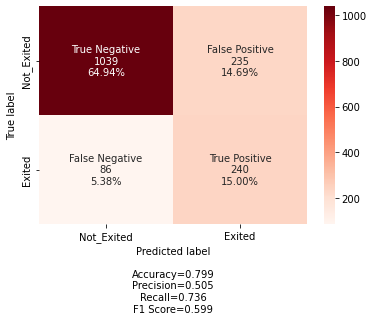

In [22]:
# Plot Confusion Matrix and Classification report

cm1=confusion_matrix(y_val, y_pred_3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')
cr=metrics.classification_report(y_val,y_pred_3)
print(cr)

# Model 2

In [23]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
import random
random.seed(2)
tf.random.set_seed(2)

In [24]:
#Initializing the neural network
model_2 = Sequential()

model_2.add(Dense(64,activation='relu',input_dim = X_train.shape[1]))
model_2.add(Dropout(0.3))
model_2.add(Dense(16,activation='relu', kernel_initializer = 'he_normal'))
model_2.add(Dropout(0.3))
model_2.add(Dense(8,activation='relu', kernel_initializer = 'he_normal'))
model_2.add(Dense(1, activation = 'sigmoid'))

In [25]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [26]:
# Defining Early stopping
from keras import callbacks 
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

In [27]:
# Fit the model 
history_2 = model_2.fit(X_train,y_train,batch_size=128,epochs=100,verbose=0,validation_data=(X_val,y_val),callbacks=[es_cb])

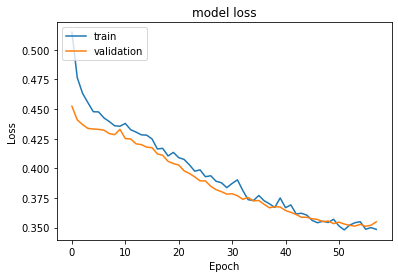

In [28]:
# Plot the Loss 
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

200/200 [==============================] - 0s 1ms/step
Best Threshold=0.224220, G-Mean=0.798


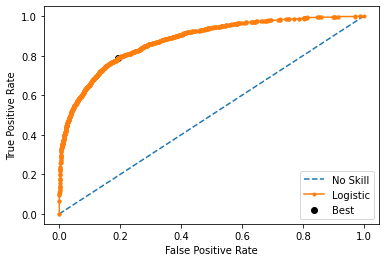

In [29]:
# Balance performance classification threshold with ROC curves

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat = model_2.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [30]:
#Predicting the results using best as a threshold
y_pred_e=model_2.predict(X_val)
y_pred_2 = (y_pred_e > thresholds[ix])

50/50 [==============================] - 0s 1ms/step


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1274
           1       0.49      0.75      0.59       326

    accuracy                           0.79      1600
   macro avg       0.71      0.78      0.73      1600
weighted avg       0.84      0.79      0.80      1600



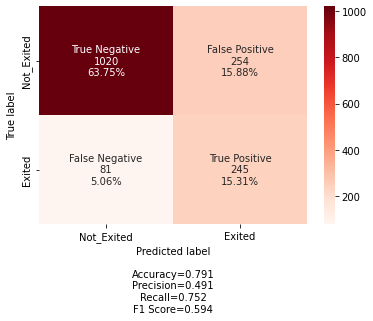

In [31]:
# Plot Confusion Matrix and Classification report

cm1=confusion_matrix(y_val, y_pred_2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')
cr=metrics.classification_report(y_val,y_pred_2)
print(cr)

# Predict the test data X_test

200/200 [==============================] - 0s 2ms/step
Best Threshold=0.224220, G-Mean=0.798


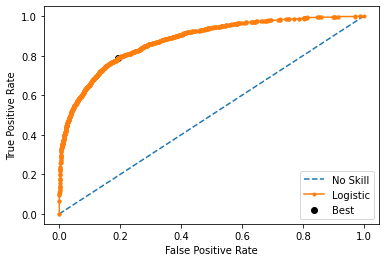

In [68]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities using the best model
yhat = model_2.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.76      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000



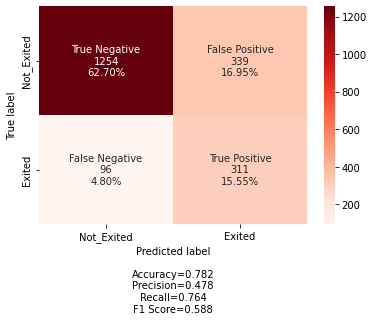

In [69]:
#Predicting and ploting results

y_pred_test = model_2.predict(X_test)
y_pred_test = (y_pred_test > thresholds[ix])
cm1=confusion_matrix(y_test, y_pred_test)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')
cr=metrics.classification_report(y_test,y_pred_test)
print(cr)

In [33]:
pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [34]:
import shap

In [36]:
X_train.shape

(6400, 11)

In [37]:
#Take a sample of train data, because if you use all the data it could cause slower run times
background = X_train.sample(n = 1000)

In [38]:
#Applying shap import shap
explainer = shap.KernelExplainer(model_2.predict,background)

32/32 [==============================] - 0s 1ms/step


In [39]:
X_test_shap = X_test.sample(n=100)

In [40]:
shap_values = explainer.shap_values(X_test_shap, nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

3125/3125 [==============================] - 5s 2ms/step


In [41]:
# Storing features(variable) name
features = X_train.columns

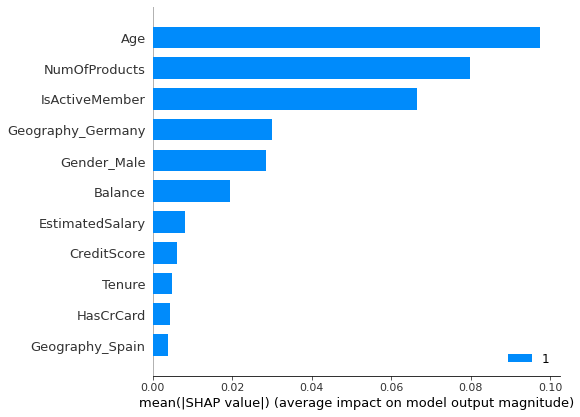

In [67]:
# Plotting the feature importance
shap.summary_plot(shap_values,X_test,feature_names=features, class_names=class_names)